### Imports

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


from utils.dataset.dataset import create_fiftyone_dataset, FiftyOneTorchDataset, get_transform, CLASSES

import wandb

import os
import sys

from utils.vision.engine import train_one_epoch, evaluate

import utils.vision.utils as utils
import utils.vision.transforms as T

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Creating Datasets

In [3]:
wanted_classes = "signals"
wanted_model = "faster_RCNN"

In [4]:
fo_test_set = create_fiftyone_dataset(
        wanted_classes, "validation", drop_existing_dataset=False
    )
fo_test_set.compute_metadata()

test_set = FiftyOneTorchDataset(fo_test_set, get_transform(train=False))

num_classes = len(test_set.classes)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn,
)

Found annotations at 'C:\Users\stani\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'validation_signals'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Constructing the models

model = our trained model

full_model = model trained on all COCO

In [5]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# get the trained weights
model.load_state_dict(torch.load("results/faster_RCNN/signals/all_losses_retake_lr_1e-4/model.pt"))

model.to(device)
model.eval()
pass

c:\Users\stani\anaconda3\envs\coco\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\stani\anaconda3\envs\coco\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# load a model pre-trained pre-trained on COCO
full_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
full_model.to(device)
full_model.eval()
pass

### Evaluations

In [7]:
test_metric = evaluate(model, test_loader, device)

creating index...
index created!
Test:  [  0/560]  eta: 1:30:02  model_time: 9.6001 (9.6001)  evaluator_time: 0.0186 (0.0186)  time: 9.6467  data: 0.0260  max mem: 678
Test:  [100/560]  eta: 0:01:47  model_time: 0.1200 (0.2166)  evaluator_time: 0.0010 (0.0026)  time: 0.1388  data: 0.0132  max mem: 752
Test:  [200/560]  eta: 0:01:07  model_time: 0.1230 (0.1710)  evaluator_time: 0.0010 (0.0029)  time: 0.1410  data: 0.0144  max mem: 752
Test:  [300/560]  eta: 0:00:45  model_time: 0.1260 (0.1568)  evaluator_time: 0.0010 (0.0027)  time: 0.1495  data: 0.0146  max mem: 752
Test:  [400/560]  eta: 0:00:27  model_time: 0.1380 (0.1526)  evaluator_time: 0.0020 (0.0026)  time: 0.1578  data: 0.0128  max mem: 752
Test:  [500/560]  eta: 0:00:10  model_time: 0.1470 (0.1512)  evaluator_time: 0.0020 (0.0026)  time: 0.1618  data: 0.0135  max mem: 752
Test:  [559/560]  eta: 0:00:00  model_time: 0.1410 (0.1505)  evaluator_time: 0.0020 (0.0026)  time: 0.1616  data: 0.0132  max mem: 752
Test: Total time: 0:01

In [8]:
full_test_metric = evaluate(full_model, test_loader, device, True, test_set.get_classes())

creating index...
index created!
Test:  [  0/560]  eta: 0:03:14  model_time: 0.3320 (0.3320)  evaluator_time: 0.0030 (0.0030)  time: 0.3470  data: 0.0100  max mem: 752
Test:  [100/560]  eta: 0:01:46  model_time: 0.1410 (0.2006)  evaluator_time: 0.0020 (0.0047)  time: 0.1616  data: 0.0146  max mem: 752
Test:  [200/560]  eta: 0:01:12  model_time: 0.1560 (0.1762)  evaluator_time: 0.0020 (0.0037)  time: 0.1755  data: 0.0165  max mem: 752
Test:  [300/560]  eta: 0:00:49  model_time: 0.1470 (0.1676)  evaluator_time: 0.0020 (0.0033)  time: 0.1673  data: 0.0160  max mem: 752
Test:  [400/560]  eta: 0:00:30  model_time: 0.1560 (0.1649)  evaluator_time: 0.0020 (0.0033)  time: 0.1797  data: 0.0179  max mem: 752
Test:  [500/560]  eta: 0:00:11  model_time: 0.1890 (0.1661)  evaluator_time: 0.0040 (0.0034)  time: 0.2546  data: 0.0240  max mem: 752
Test:  [559/560]  eta: 0:00:00  model_time: 0.1852 (0.1688)  evaluator_time: 0.0030 (0.0036)  time: 0.2187  data: 0.0249  max mem: 752
Test: Total time: 0:01

In [9]:
print("Our model mAP :", test_metric.coco_eval["bbox"].stats[0])
print("Full COCO trained model mAP :", full_test_metric.coco_eval["bbox"].stats[0])

Our model mAP : 0.475842758076396
Full COCO trained model mAP : 0.4404059795106599


### Toy example on a test_image

In [10]:
for test_image, test_targets in test_loader :
    break

In [11]:
test_image = list(img.to(device) for img in test_image)

In [12]:
from matplotlib import pyplot as plt

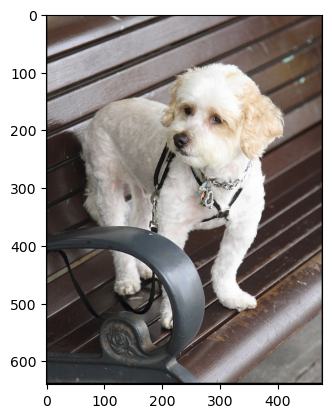

In [13]:
plt.imshow(test_image[0].cpu().permute(1, 2, 0))

In [14]:
test_image[0].shape

torch.Size([3, 640, 478])

In [15]:
full_output = full_model(test_image)[0]
output = model(test_image)[0]

In [16]:
for label in test_targets[0]["labels"] :
    if label != 0 :
        print(test_set.get_classes()[label])

bench


In [17]:
processed_full_output = full_output.copy()
for i, label in enumerate(processed_full_output["labels"]) :
    if CLASSES[label] in test_set.get_classes() :
        processed_full_output["labels"][i] = test_set.get_classes().index(CLASSES[label])
    else :
        processed_full_output["labels"][i] = 0

In [18]:
for label in processed_full_output["labels"] :
    if label != 0 :
        print(test_set.get_classes()[label])

bench
bench


In [19]:
for label in output["labels"] :
    if label != 0 :
        print(test_set.get_classes()[label])

bench
bench
bench
bench
bench
bench
bench
